In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
from matplotlib.path import Path
import matplotlib.patches as patches
from scipy import stats

In [12]:
class HMM_Simulator(object):

    def __init__(self, map_size, obs_size, obstacles=None):

        #### Defining parameters and variables ####
        ## Probability of robot staying in the same state
        self.p_stay = 0.2
        # Probability of robot observing given state correctly
        self.p_truesignal = 0.7
        # Size of the gridworld
        self.map_size = map_size  # Size of one edge of grid world
        self.state_size = map_size * map_size  # Total number of state
        self.obs_size = obs_size  # Total number of observation
        # Noise of the robot

        # Transition matrix of the simulator, initilize without any obstacles
        # Size is num_state x num_state
        self.T = np.zeros((self.state_size, self.state_size))

        # Observation matrix of the simulator, num_state x num_obs
        self.M = np.zeros((self.state_size, self.obs_size))

        # True identity of the states, the index corresponds to the state
        self.S_type = np.random.choice(self.obs_size, self.state_size)

        # Keep track of any obstacles
        self.obstacles = obstacles
        if self.obstacles is None:
            self.valid_states = list(set(range(self.state_size)))
        else:
            self.valid_states = list(set(range(self.state_size)) - set(self.obstacles))

        ## First classify the states into different types
        self.corner_states = [0, self.map_size - 1,
                              self.state_size - self.map_size, self.state_size - 1]
        self.north_edge_states = list(range(1, self.map_size - 1))
        self.west_edge_states = list(range(self.map_size, self.state_size - self.map_size,
                                           self.map_size))
        self.east_edge_states = list(range(self.map_size * 2 - 1, self.state_size - self.map_size,
                                           self.map_size))
        self.south_edge_states = list(range(self.state_size - self.map_size - 1, self.state_size - 1))
        self.middle_states = sorted(list(set(range(self.map_size - 1)) - \
                                         set(self.corner_states) - \
                                         set(self.north_edge_states) - \
                                         set(self.west_edge_states) - \
                                         set(self.east_edge_states) - \
                                         set(self.south_edge_states)))

        #### Updating the matrices according to the map ####

        # Fill in the transition matrix
        ## Second iterate through all the states and fill the transition matrix
        ### Determine corner case
        for s in self.corner_states:
            prow = np.zeros(self.state_size)
            prow[s] = self.p_stay + (1.0 - self.p_stay) / 2
            if s == 0:
                prow[1] = (1.0 - self.p_stay) / 4.0
                prow[self.map_size] = (1.0 - self.p_stay) / 4.0
            elif s == (self.map_size - 1):
                prow[self.map_size - 2] = (1.0 - self.p_stay) / 4.0
                prow[s + self.map_size] = (1.0 - self.p_stay) / 4.0
            elif s == (self.state_size - self.map_size - 1):
                prow[self.state_size - 2 * self.map_size] = (1.0 - self.p_stay) / 4.0
                prow[self.state_size - 2 * self.map_size + 1] = (1.0 - self.p_stay) / 4.0
            else:
                prow[self.state_size - 2] = (1.0 - self.p_stay) / 4.0
                prow[self.state_size - self.map_size - 1] = (1.0 - self.p_stay) / 4.0

            self.T[s, :] = prow

        ### Determine the rest
        for s in range(self.state_size):
            if s in self.corner_states:
                continue;
            prow = np.zeros(self.state_size)
            if s in self.north_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s - 1] = (1.0 - self.p_stay) / 4
                prow[s + 1] = (1.0 - self.p_stay) / 4
                prow[s + self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.east_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s - self.map_size] = (1.0 - self.p_stay) / 4
                prow[s - 1] = (1.0 - self.p_stay) / 4
                prow[s + self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.west_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s - self.map_size] = (1.0 - self.p_stay) / 4
                prow[s + 1] = (1.0 - self.p_stay) / 4
                prow[s + self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.south_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s - self.map_size] = (1.0 - self.p_stay) / 4
                prow[s + 1] = (1.0 - self.p_stay) / 4
                prow[s - 1] = (1.0 - self.p_stay) / 4
            else:
                prow[s] = self.p_stay
                prow[s - self.map_size] = (1.0 - self.p_stay) / 4
                prow[s + 1] = (1.0 - self.p_stay) / 4
                prow[s - 1] = (1.0 - self.p_stay) / 4
                prow[s + self.map_size] = (1.0 - self.p_stay) / 4

            self.T[s, :] = prow

        # Fill in the observation matrix
        for i in range(self.state_size):
            m_row = np.array([0.7 if k == self.S_type[i] else
                              0.3 / (self.obs_size - 1) for k in range(self.obs_size)])
            self.M[i, :] = m_row

    # Generate data randomly, robot will go to any station uniformly
    # and observe the state according to M matrix
    # Return the true state locations and the observation at give time t
    def random_generate(self, N):
        Z = np.zeros(N)
        X = np.random.choice(self.valid_states, N)
        for t in range(N):
            Z[t] = np.random.choice(list(range(self.obs_size)), 1, p=self.M[X[t], :])

        return (X, Z)

    # Generate the data according to the transition matrix,
    # The robot moves one state at a time and observe one observation at a time
    # Return the true state locations and the observation at given time t
    # Robot starts at a random location
    def normal_generate(self, N):
        Z = np.zeros(N)
        X = np.zeros(N)

        current_state = np.random.choice(self.valid_states, 1)[0]

        for t in range(N):
            current_state = np.random.choice(list(range(self.state_size)), 1, p=self.T[current_state, :])[0]
            X[t] = current_state
            Z[t] = np.random.choice(list(range(self.obs_size)), 1, p=self.M[int(X[t]), :])

        return (X, Z)

    # Generate array of multiple trajectories
    # Returns two arrays (X_num, Z_num) of shape num x N
    def multi_generate(self, N, num=1, path_type="normal_generate"):
        path_method = getattr(self, path_type)
        X_list = []
        Z_list = []
        for _ in range(num):
            X, Z = path_method(N)
            X_list.append(X)
            Z_list.append(Z)
        X_num = np.stack(X_list)
        Z_num = np.stack(Z_list)
        return X_num, Z_num

    ## Normalize the T matrix
    def T_normalize(self, T):
        row_sums = T.sum(axis=1)
        T = T / row_sums[:, np.newaxis]
        return T

    # Generate the data when there is correlation between more than one past states
    # to the next movement
    # Set up matrix W that correspond to the number of the state,
    # Each time robot moves to an even state, the transition matrix is perturbed by W
    def corr_generate(self, N):
        # Some condition, if this is true, then multiply the transition matrix with W
        cond = lambda x : x % 2 == 0
        # Same process as the normal generate
        Z = np.zeros(N)
        X = np.zeros(N)
        current_state = np.random.choice(self.valid_states, 1)[0]
        # We will use the copy of the transition matrix in order to preserve the T
        T_corr = np.copy(self.T)
        
        for t in range(N):
            if cond(current_state):
                W = np.copy(T_corr)
                
                W[np.where(W != 0)] = stats.truncnorm.rvs(1, 100, loc=1, scale = 0.01, 
                                                          size=len(W[np.where(W!=0)]))
                
                T_corr = T_corr * W
                self.T_normalize(T_corr)
            current_state = np.random.choice(list(range(self.state_size)), 1, 
                                             p=T_corr[current_state, :])[0]
            X[t] = current_state
            Z[t] = np.random.choice(list(range(self.obs_size)), 1, p=self.M[int(X[t]), :])

        return (X, Z)

    def perturb_transition(self):
        
        for s in self.valid_states:
            new_prob = np.copy(self.T[s, :])
            new_prob[s] = round(np.random.uniform(0.1, 0.3), 2)
            available = np.where(new_prob != 0)[0]
            # Perturb the prob of staying in by uniform
            diff = (self.T[s, s] - new_prob[s]) / (len(available) - 1)
            for j in available:
                if s != j:
                    new_prob[j] += diff
            self.T[s, :] = new_prob

        return

    # Fill the world with random obstacles of given size
    # Adjust T and M accordingly
    def fill_random_obstacle(self, num_obstacles):

        if num_obstacles > self.state_size:
            raise NameError("Too Many Obstacles!")

        valid_map = False

        while not valid_map:
            new_M = np.copy(self.M)
            new_T = np.copy(self.T)
            new_obstacles = sorted(np.random.choice(list(range(self.state_size)), 
                                                    num_obstacles, replace=False))

            for o in new_obstacles:
                contig = sorted(self.find_contiguous_state(o))
                for c in contig:
                    if c in new_obstacles:
                        continue
                    else:
                        new_T[c, c] += new_T[c, o]
                        new_T[c, o] = 0
                        new_M[o, :] = 0
            # Check whether the new map candidate is valid
            if (new_T != 1).all():
                valid_map = True

        self.M = new_M
        self.T = new_T
        self.obstacles = new_obstacles
        self.valid_states = list(set(range(self.state_size)) - set(self.obstacles))

        return

    ## Return the states that are continguous to give state
    def find_contiguous_state(self, s):
        contiguous = []

        if (s % self.map_size != 0):
            contiguous.append(s - 1)

        if ((s + 1) % self.map_size != 0):
            contiguous.append(s + 1)

        if (s - self.map_size > 0):
            contiguous.append(s - self.map_size)

        if (s + self.map_size < self.state_size):
            contiguous.append(s + self.map_size)

        return (contiguous)

    # Show the map
    def draw_world(self):
        fig = pyplot.figure()
        ax = fig.add_subplot(111)

        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            labelbottom=False,
            labelleft=False)

        size = 10
        for i in range(self.map_size + 1):
            ax.plot([0, self.map_size * size], [i * size, i * size], 'k-')

        for i in range(self.map_size + 1):
            ax.plot([i * size, i * size], [0, self.map_size * size], 'k-')

        if self.obstacles is not None:
            for s in self.obstacles:
                # Draw the obstacles
                x = s % self.map_size
                y = self.map_size - s // self.map_size - 1
                verts = [
                    (x * size, y * size),
                    (x * size, (y + 1) * size),
                    ((x + 1) * size, (y + 1) * size),
                    ((x + 1) * size, y * size),
                    (x * size, y * size),
                ]

                codes = [Path.MOVETO,
                         Path.LINETO,
                         Path.LINETO,
                         Path.LINETO,
                         Path.CLOSEPOLY,
                         ]

                path = Path(verts, codes)

                patch = patches.PathPatch(path, facecolor='black', lw=1)
                ax.add_patch(patch)

        for s in self.valid_states:
            x = s % self.map_size
            y = self.map_size - s // self.map_size - 1
            name = self.S_type[s]
            ax.text((x + 0.4) * size, (y + 0.45) * size, name)
            
        pyplot.savefig("mapping.png")
        pyplot.show()
        
        
    # function that generates the data in the txt format
    # Save the observation and the true states in a separate file.
    # Generate the data in 3 different ways (Normal, Random and Correlated)
    def generate_txt(self, steps, seq_n, name):
        
        normal_seq = h.multi_generate(N = steps, num = seq_n, path_type = "normal_generate")
        random_seq = h.multi_generate(N = steps, num = seq_n, path_type = "random_generate")
        corr_seq = h.multi_generate(N = steps, num = seq_n, path_type = "corr_generate")
        
        np.savetxt("{}_normal_state.txt".format(name), X = normal_seq[0], 
                   delimiter=" ", newline="\n;\n", fmt='%1.0i')
        np.savetxt("{}_normal_obs.txt".format(name), X = normal_seq[1], 
                   delimiter=" ", newline="\n;\n", fmt='%1.0i')
        np.savetxt("{}_random_state.txt".format(name), X = random_seq[0], 
                   delimiter=" ", newline="\n;\n", fmt='%1.0i')
        np.savetxt("{}_random_obs.txt".format(name), X = random_seq[1], 
                   delimiter=" ", newline="\n;\n", fmt='%1.0i')
        np.savetxt("{}_corr_state.txt".format(name), X = corr_seq[0], 
                   delimiter=" ", newline="\n;\n", fmt='%1.0i')
        np.savetxt("{}_corr_obs.txt".format(name), X = corr_seq[1], 
                   delimiter=" ", newline="\n;\n", fmt='%1.0i')
        
        return
        

In [13]:
np.random.seed(123)

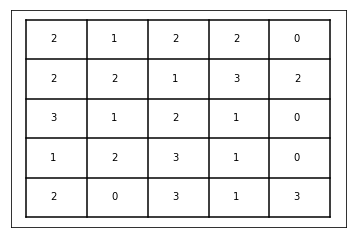

ValueError: probabilities do not sum to 1

In [14]:
# Build State cases - Map Description
# Profile 1 - Size: 5x5, Obs_size: 4, no obstacle
h = HMM_Simulator(5, 4)
h.perturb_transition()
h.draw_world()
d = h.generate_txt(seq_n = 10, steps = 200, name = "5x5;4;free")

In [ ]:
# Build State cases - Map Description
# Profile 2 - Size: 5x5, Obs_size: 4, 6 obstacles
h = HMM_Simulator(5, 4, obstacles=[4, 6, 7, 12, 19, 20])
h.perturb_transition()
h.draw_world()
d = h.generate_txt(seq_n = 10, steps = 200, name = "5x5;4;6box")

In [ ]:
# Build State cases - Map Description
# Profile 2 - Size: 5x5, Obs_size: 4, 6 obstacles
# Separated World
h = HMM_Simulator(5, 4, obstacles=[9,10,11,12,14,16])
h.perturb_transition()
h.draw_world()
d = h.generate_txt(seq_n = 10, steps = 200, name = "5x5;4;6sep")